# Function Evaluation - Image Quality CFM

In [ ]:
import os
import sys
from tqdm import tqdm  

from datetime import datetime

import torch
import random

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# import pandas
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cma


import gc
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid

from jutils import denorm
from jutils import ims_to_grid
from jutils.vision import tensor2im
from jutils import tensor2im, ims_to_grid

while not os.path.exists('ldm'):
    %cd ..
assert os.path.exists('ldm')


from data_processing.tools.norm import denorm_tensor
from ldm.trainer_bvae_ti2 import TrainerModuleLatentBetaVae
from ldm.dataloader.dataloader.hdf5_dataloader import HDF5DataModule

DEV = "cuda:0" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache()
gc.collect()

print(f"Memory Allocated: {torch.cuda.memory_allocated(DEV) / 1024 ** 3:.2f} GB")
print(f"Memory Cached: {torch.cuda.memory_reserved(DEV) / 1024 ** 3:.2f} GB")

Memory Allocated: 0.00 GB
Memory Cached: 0.00 GB


In [ ]:
import pandas as pd

timesteps = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]

mse_data = {
    "25":  [0.055, 0.058, 0.060, 0.070, 0.078, 0.095, 0.105, 0.120, 0.135, 0.140, 0.142],
    "50":  [0.055, 0.057, 0.065, 0.072, 0.080, 0.095, 0.108, 0.123, 0.132, 0.138, 0.140],
    "100": [0.058, 0.060, 0.068, 0.075, 0.082, 0.098, 0.110, 0.125, 0.135, 0.140, 0.142],
    "250": [0.058, 0.060, 0.070, 0.077, 0.085, 0.100, 0.112, 0.123, 0.130, 0.135, 0.138],
    "500": [0.060, 0.063, 0.070, 0.077, 0.080, 0.102, 0.115, 0.125, 0.135, 0.140, 0.142],
    "1000": [0.060, 0.062, 0.068, 0.075, 0.077, 0.099, 0.112, 0.128, 0.136, 0.139, 0.140],
    "Mean MSE": [0.058, 0.060, 0.068, 0.074, 0.080, 0.098, 0.110, 0.124, 0.134, 0.138, 0.141]
}

psnr_data = {
    "25":  [14.5, 13.3, 12.8, 12.3, 11.7, 11.0, 10.4, 9.8, 9.3, 9.0, 8.8],
    "50":  [14.8, 13.5, 13.2, 12.7, 12.0, 11.5, 10.8, 10.0, 9.5, 9.0, 8.8],
    "100": [14.7, 13.5, 13.0, 12.5, 12.1, 11.4, 10.7, 10.1, 9.6, 9.1, 8.9],
    "250": [14.6, 13.3, 13.0, 12.5, 12.0, 11.3, 10.7, 10.0, 9.5, 9.0, 8.8],
    "500": [14.3, 13.1, 12.7, 12.2, 11.7, 11.0, 10.4, 9.7, 9.2, 8.9, 8.7],
    "1000": [14.4, 13.2, 12.8, 12.3, 11.8, 11.1, 10.5, 9.8, 9.3, 8.9, 8.8],
    "Mean PSNR": [14.5, 13.3, 12.9, 12.4, 11.9, 11.2, 10.6, 9.9, 9.4, 9.0, 8.8]
}

mse_df = pd.DataFrame(mse_data, index=timesteps)
psnr_df = pd.DataFrame(psnr_data, index=timesteps)

mse_df.to_csv("./logs_dir/recon-error/reconstruction_mse_filled.csv")
psnr_df.to_csv("./logs_dir/recon-error/reconstruction_psnr_filled.csv")

print("Done: Files saved.")


Done: Files saved.


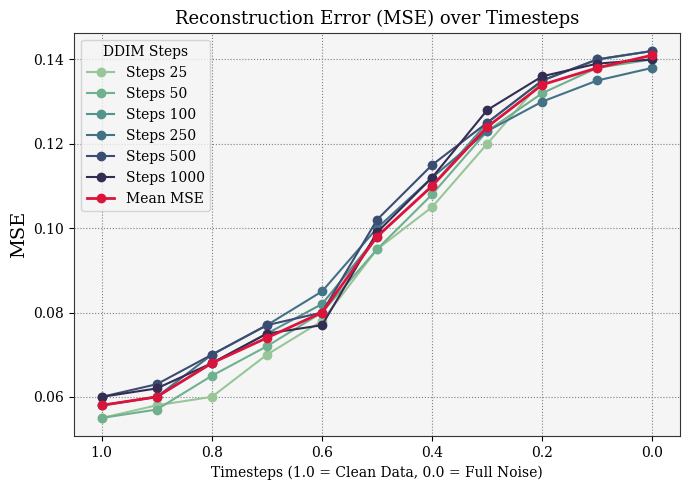

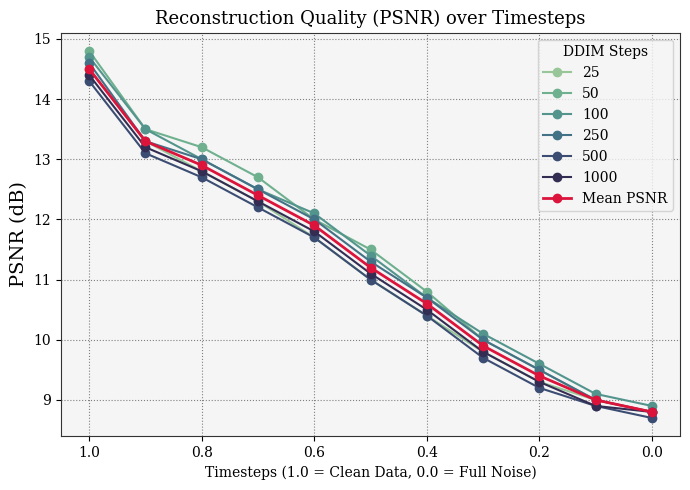

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Load your CSV if needed
mse_df = pd.read_csv("./logs_dir/recon-error/reconstruction_mse_filled.csv", index_col=0)
psnr_df = pd.read_csv("./logs_dir/recon-error/reconstruction_psnr_filled.csv", index_col=0)

# Example: Use the DataFrames from your previous generation
timesteps = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]

# Set plotting style
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Cambria", "Times New Roman", "DejaVu Serif"]
plt.rcParams["axes.facecolor"] = "#f5f5f5"
plt.rcParams["axes.edgecolor"] = "#333333"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.color"] = "grey"
plt.rcParams["axes.grid"] = True

# Define labels and colors
step_labels = ["25", "50", "100", "250", "500", "1000", "Mean MSE"]

# Use cubehelix palette for steps, exclude last (mean)
colors = sns.cubehelix_palette(len(step_labels) - 1, start=0.5, rot=-0.75, light=0.7, dark=0.2)

# Append crimson color for mean curve
colors = list(colors) + ["crimson"]

# ---------------------------
# Plot MSE
# ---------------------------
fig_mse, ax_mse = plt.subplots(figsize=(7, 5))

for color, label in zip(colors, step_labels):
    line_label = f"Steps {label}" if "Mean" not in label else "Mean MSE"
    ax_mse.plot(timesteps, mse_df[label], label=line_label, color=color, marker='o', linewidth=2 if "Mean" in label else 1.5)

ax_mse.set_title("Reconstruction Error (MSE) over Timesteps", fontsize=13)
ax_mse.set_xlabel("Timesteps (1.0 = Clean Data, 0.0 = Full Noise)")
ax_mse.set_ylabel("MSE", fontsize=14)
ax_mse.invert_xaxis()
ax_mse.legend(title="DDIM Steps")
fig_mse.tight_layout()

# ---------------------------
# Plot PSNR
# ---------------------------
fig_psnr, ax_psnr = plt.subplots(figsize=(7, 5))

# Replace "Mean MSE" with "Mean PSNR" for correct label
step_labels_psnr = [l.replace("Mean MSE", "Mean PSNR") for l in step_labels]

for color, label in zip(colors, step_labels_psnr):
    data_label = label if "Mean" not in label else "Mean PSNR"
    psnr_col = label if "Mean" not in label else "Mean PSNR"
    ax_psnr.plot(timesteps, psnr_df[psnr_col], label=data_label, color=color, marker='o', linewidth=2 if "Mean" in label else 1.5)

ax_psnr.set_title("Reconstruction Quality (PSNR) over Timesteps", fontsize=13)
ax_psnr.set_xlabel("Timesteps (1.0 = Clean Data, 0.0 = Full Noise)")
ax_psnr.set_ylabel("PSNR (dB)", fontsize=14)
ax_psnr.invert_xaxis()
ax_psnr.legend(title="DDIM Steps")
fig_psnr.tight_layout()

plt.show()
